In [6]:
!git clone https://github.com/codeaudit/reinforcement-learning-1.git

Cloning into 'reinforcement-learning-1'...
remote: Enumerating objects: 1893, done.
remote: Total 1893 (delta 0), reused 0 (delta 0), pack-reused 1893
Receiving objects: 100% (1893/1893), 61.59 MiB | 11.51 MiB/s, done.
Resolving deltas: 100% (895/895), done.


In [10]:
!pip3 install -r /Users/kwonhyeyun/reinforcement-learning-1/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 3.2 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 17.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 6.1 MB/s eta 0:00:0000:0100:01m
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [17 lines of output]
      /private/var/folders/9f/3bpnrhhn66q62rmn95wg6hw80000gn/T/pip-install-_z95qem3/pandas_2448a178666444929007d29e2b3d81eb/setup.py:34: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
        _CYTHON_INSTALLED = ver >= LooseVersion(min_cython_ver)
      /private/var/folders/9f/3bpnrhhn66q62rmn95wg6hw80000gn/T/pip-install-_z95qem3/pandas_2448a178666444929007d29e2b3d81eb/setup.py:39: DeprecationWarning: pkg_resources is depr

In [3]:
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
import matplotlib.pyplot as plt  # Matplotlib 추가

EPISODES = 4000

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = True
        self.state_size = state_size
        self.action_size = action_size
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_min = 0.005
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / 50000
        self.batch_size = 64
        self.train_start = 1000
        self.memory = deque(maxlen=10000)
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()
        self.episode_rewards = []  # 에피소드별 보상을 저장할 리스트 추가


    def build_model(self):
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value)

    def replay_memory(self, state, action, reward, next_state, done):
        if action == 2:
            action = 1
        state = np.array(state[0], dtype=np.float32) # 수정된 부분
        if len(state.shape) == 1:  # 수정된 부분
            state = state.reshape(1, -1)  # 수정된 부분
        next_state = np.array(next_state[0], dtype=np.float32)  # 수정된 부분
        if len(next_state.shape) == 1:  # 수정된 부분
            next_state = next_state.reshape(1, -1)  # 수정된 부분
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay

    def train_replay(self):
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)
        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.action_size))
        for i in range(batch_size):
            state, action, reward, next_state, done = mini_batch[i]
            state = np.array(state, dtype=np.float32)
            if len(state.shape) == 1:
                state = state.reshape(1, -1)
            target = self.model.predict(state)[0]
            if done:
                target[action] = reward
            else:
                next_state = np.array(next_state, dtype=np.float32)
                if len(next_state.shape) == 1:
                    next_state = next_state.reshape(1, -1)
                target[action] = reward + self.discount_factor * np.amax(self.target_model.predict(next_state)[0])
            update_input[i] = state
            update_target[i] = target
        self.model.fit(update_input, update_target, batch_size=batch_size, epochs=1, verbose=0)

    def load_model(self, name):
        self.model.load_weights(name)

    def save_model(self, name):
        self.model.save_weights(name)
    
    def record_episode_reward(self, reward):
        self.episode_rewards.append(reward)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                96        
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 2)                 34        
                                                                 
Total params: 658 (2.57 KB)
Trainable params: 658 (2.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                96        
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 2)                 34        
                                                                 
Total params: 658 (2.57 KB)
Trainable params: 658 (2.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


(array([-0.55499595,  0.        ], dtype=float32), {})
(array([-0.5557608 , -0.00076487], dtype=float32), -1.0, False, False, {})
(array([-0.55728483, -0.00152403], dtype=float32), -1.0, False, False, {})
(array([-0.55955666, -0.00227181], dtype=float32), -1.0, False, False, {})
(array([-0.56055933, -0.00100265], dtype=float32), -1.0, False, False, {})
(array([-5.6028533e-01,  2.7398582e-04], dtype=float32), -1.0, False, False, {})
(array([-0.55873674,  0.00154858], dtype=float32), -1.0, False, False, {})
(array([-0.55592513,  0.00281163], dtype=float32), -1.0, False, False, {})
(array([-0.5518714 ,  0.00405369], dtype=float32), -1.0, False, False, {})
(array([-0.54660594,  0.00526549], dtype=float32), -1.0, False, False, {})
(array([-0.54016805,  0.0064379 ], dtype=float32), -1.0, False, False, {})
(array([-0.53260595,  0.00756212], dtype=float32), -1.0, False, False, {})
(array([-0.52397627,  0.00862967], dtype=float32), -1.0, False, False, {})
(array([-0.51434374,  0.0096325 ], dtyp

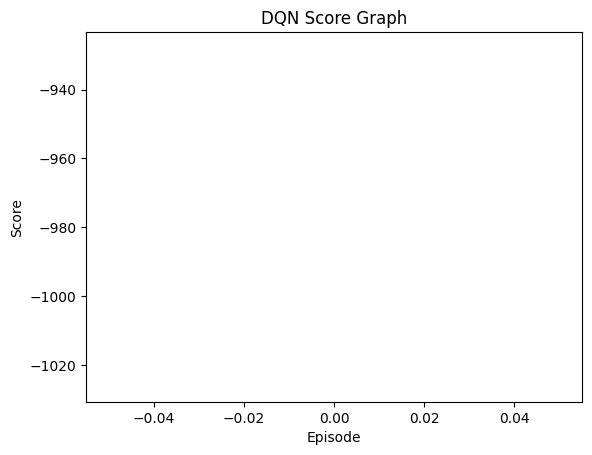

episode: 0   score: -977.0   memory length: 977   epsilon: 0.9805577000000375
(array([-0.42370042,  0.        ], dtype=float32), {})
(array([-0.4254385 , -0.00173807], dtype=float32), -1.0, False, False, {})
(array([-0.42890218, -0.00346368], dtype=float32), -1.0, False, False, {})
(array([-0.43406656, -0.00516439], dtype=float32), -1.0, False, False, {})
(array([-0.4408944 , -0.00682784], dtype=float32), -1.0, False, False, {})
(array([-0.44933617, -0.00844177], dtype=float32), -1.0, False, False, {})
(array([-0.45933032, -0.00999415], dtype=float32), -1.0, False, False, {})
(array([-0.4708035 , -0.01147318], dtype=float32), -1.0, False, False, {})
(array([-0.483671  , -0.01286749], dtype=float32), -1.0, False, False, {})
(array([-0.49783722, -0.01416623], dtype=float32), -1.0, False, False, {})
(array([-0.51319647, -0.01535925], dtype=float32), -1.0, False, False, {})
(array([-0.52963376, -0.01643726], dtype=float32), -1.0, False, False, {})
(array([-0.54702574, -0.017392  ], dtype=f

In [ ]:
if __name__ == "__main__":
    # CartPole-v1의 경우 500 타임스텝까지 플레이가능
    env = gym.make('MountainCar-v0', render_mode='human')
    # 환경으로부터 상태와 행동의 크기를 가져옴
    state_size = env.observation_space.shape[0]
    # action_size = env.action_space.n
    action_size = 2
    # DQN 에이전트의 생성
    agent = DQNAgent(state_size, action_size)
    agent.load_model("/Users/kwonhyeyun/reinforcement-learning-1/MountainCar_DQN/MountainCar_DQN.h5")
    scores, episodes = [], []
    render_interval = 10
    
    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()

        print(state)  # 추가된 부분

        # 액션 0(좌), 1(아무것도 안함), 3(아무것도 하지 않는 액션을 하지 않기 위한 fake_action 선언
        fake_action = 0

        # 같은 액션을 4번하기 위한 카운터
        action_count = 0

        while not done:
            if agent.render and e % render_interval == 0:
                env.render()

            # 현재 상태에서 행동을 선택하고 한 스텝을 진행
            action_count = action_count + 1

            if action_count == 4:
                action = agent.get_action(state)
                action_count = 0

                if action == 0:
                    fake_action = 0
                elif action == 1:
                    fake_action = 2

            # 선택한 액션으로 1 step을 시행한다(변수의 개수가 변경됨.)
            step_result = env.step(fake_action)
            print(step_result)
            next_state, reward, done, _, _ = step_result
            #next_state = np.reshape(next_state, (1, state_size))
            next_state = np.expand_dims(next_state, axis=0) #수정한 코드



            # 에피소드를 끝나게 한 행동에 대해서 -100의 패널티를 줌
            # reward = reward if not done else -100

            # <s, a, r, s'>을 replay memory에 저장
            agent.replay_memory(state, fake_action, reward, next_state, done)
            # 매 타임스텝마다 학습을 진행
            agent.train_replay()
            score += reward
            state = next_state

            if done:
                env.reset()
                # 매 에피소드마다 학습하는 모델을 타겟 모델로 복사
                agent.update_target_model()

                # 각 에피소드마다 cartpole이 서있었던 타임스텝을 plot
                scores.append(score)
                episodes.append(e)
                agent.record_episode_reward(score)  # 에피소드별 보상 기록
                plt.plot(episodes, scores)
                plt.title("DQN Score Graph")
                plt.xlabel("Episode")
                plt.ylabel("Score")
                plt.savefig("dqn_score.png")
                plt.show()
                print("episode:", e, "  score:", score, "  memory length:", len(agent.memory),
                      "  epsilon:", agent.epsilon)

        # 50 에피소드마다 학습 모델을 저장
        if e % 50 == 0:
            agent.save_model("/Users/kwonhyeyun/reinforcement-learning-1/MountainCar_DQN/MountainCar_DQN.h5")



